In [3]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from keras.models import Sequential
import seaborn as sns
from keras.layers import Dense,Dropout,Activation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model
import torch_optimizer as optim
from res_mlp_pytorch import ResMLP
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imutils import paths
import cv2

In [4]:
!pip install torch_optimizer
!pip install res_mlp_pytorch
!pip install imutils

In [5]:
PATH = "../input/eyes-dataset/eyes"
train_dir = os.path.join(PATH)
train = keras.preprocessing.image_dataset_from_directory(train_dir,validation_split=(0.2),subset="training",seed=42,image_size=(75,75))
validation = keras.preprocessing.image_dataset_from_directory(train_dir,validation_split=(0.2),subset="validation",seed=42,image_size=(75,75))

Found 11509 files belonging to 2 classes.
Using 9208 files for training.


2022-04-11 01:44:31.840966: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 11509 files belonging to 2 classes.
Using 2301 files for validation.


In [6]:
train

<BatchDataset shapes: ((None, 75, 75, 3), (None,)), types: (tf.float32, tf.int32)>

2022-04-11 01:44:34.660125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


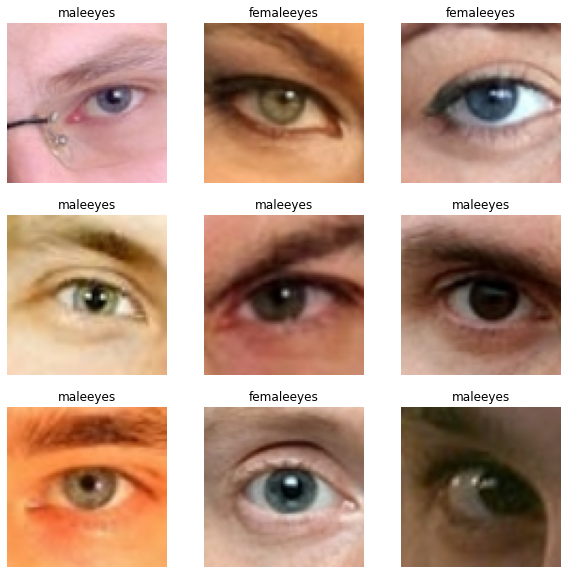

In [7]:
plt.figure(figsize=(10,10))
for images,labels in train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train.class_names[labels[i]])
        plt.axis(False)

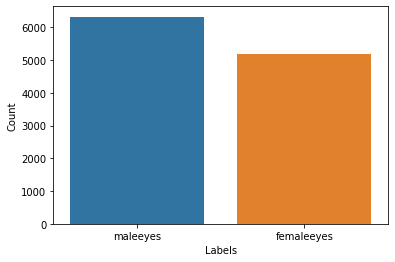

In [8]:
path_img = list(glob.glob(PATH+'/**/*.jpg'))
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count');

From the above plot, we can see that there is no data imbalance in the male and female eyes.

# # KNN Model

In [9]:
class ImgProcessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width=width
        self.height=height
        self.inter=inter

    def process(self, img):
        return cv2.resize(img, (self.width, self.height), interpolation=self.inter)

In [10]:
class DataLoader:
    def __init__(self, prepros=None):
        self.prepros=prepros
        if self.prepros is None:
            self.prepros=[]

    def load(self, imgpaths, verbose=-1):
        data = []
        labels=[]
        for(i, imgpath) in enumerate(imgpaths):
            img=cv2.imread(imgpath)
            label=imgpath.split(os.path.sep)[-2]

            if self.prepros is not None:
                for p in self.prepros:
                    img=p.process(img)

            data.append(img)
            labels.append(label)

            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1, len(imgpaths)))
        return (np.array(data), np.array(labels))

In [11]:
obs = 1
print("Loading Images:")
imgpaths=list(paths.list_images(train_dir))
ip = ImgProcessor(32, 32)
dl = DataLoader(prepros=[ip])
(data, labels) = dl.load(imgpaths, verbose=500)
data = data.reshape((data.shape[0], 3072))
print("[INFO] features matrix: {:.1f}KB".format(data.nbytes / (1024)))
print(data[1].shape)
le = LabelEncoder()
labels = le.fit_transform(labels)
(Xtrain, Xtest, ytrain, ytest) = train_test_split(data, labels, test_size=0.3, random_state=40)
model_KNN = KNeighborsClassifier(n_neighbors=4, n_jobs=1)
model_KNN.fit(Xtrain, ytrain)

Loading Images:
[INFO] processed 500/11509
[INFO] processed 1000/11509
[INFO] processed 1500/11509
[INFO] processed 2000/11509
[INFO] processed 2500/11509
[INFO] processed 3000/11509
[INFO] processed 3500/11509
[INFO] processed 4000/11509
[INFO] processed 4500/11509
[INFO] processed 5000/11509
[INFO] processed 5500/11509
[INFO] processed 6000/11509
[INFO] processed 6500/11509
[INFO] processed 7000/11509
[INFO] processed 7500/11509
[INFO] processed 8000/11509
[INFO] processed 8500/11509
[INFO] processed 9000/11509
[INFO] processed 9500/11509
[INFO] processed 10000/11509
[INFO] processed 10500/11509
[INFO] processed 11000/11509
[INFO] processed 11500/11509
[INFO] features matrix: 34527.0KB
(3072,)


KNeighborsClassifier(n_jobs=1, n_neighbors=4)

In [12]:
print(classification_report(ytest, model_KNN.predict(Xtest), target_names=le.classes_))

              precision    recall  f1-score   support

  femaleeyes       0.78      0.80      0.79      1561
    maleeyes       0.83      0.82      0.82      1892

    accuracy                           0.81      3453
   macro avg       0.81      0.81      0.81      3453
weighted avg       0.81      0.81      0.81      3453



The above model was trained using KNN Classifier from Sklearn package. As we can see from the classification report, the model achieved an accuracy of 81 percent. The precision for the maleeyes was around 83% which is better than the female eyes which is around 78%. The recall is 0.80 for the female eyes and 0.82 for the maleeyes.

## Multilayer Perceptron Model

In [13]:
from tensorflow.keras.layers import Flatten
model_mlp = Sequential()
model_mlp.add(Dense(32, activation= "relu", input_shape=(75,75,3)))
model_mlp.add(Dense(64, activation= "relu"))
model_mlp.add(Dense(128, activation= "relu"))
model_mlp.add(Flatten())
model_mlp.add(Dense(1, activation= "sigmoid"))
model_mlp.compile(loss="binary_crossentropy",metrics=["accuracy"],optimizer="adam")

The model_mlp is a Multilayer Perceptron Model. Since the label is binary, the input dimension of the output layer is set to 1 and the activation used is sigmoid. Here I am using Flatten because without it the model was giving a dimension mis match error. Hence, I am using Flatten() to get a copy of the given array of data collapsed in one dimension.

In [14]:
history_mlp = model_mlp.fit(train,validation_data=validation,epochs=10,batch_size=128)

Epoch 1/10
288/288 [==============================] - 64s 220ms/step - loss: 35.2735 - accuracy: 0.7552 - val_loss: 0.4596 - val_accuracy: 0.7875
Epoch 2/10
288/288 [==============================] - 63s 219ms/step - loss: 0.3996 - accuracy: 0.8244 - val_loss: 0.4344 - val_accuracy: 0.8231
Epoch 3/10
288/288 [==============================] - 65s 227ms/step - loss: 0.3500 - accuracy: 0.8499 - val_loss: 0.3763 - val_accuracy: 0.8479
Epoch 4/10
288/288 [==============================] - 63s 219ms/step - loss: 0.3696 - accuracy: 0.8449 - val_loss: 0.4231 - val_accuracy: 0.8414
Epoch 5/10
288/288 [==============================] - 63s 219ms/step - loss: 0.3362 - accuracy: 0.8579 - val_loss: 0.5790 - val_accuracy: 0.7844
Epoch 6/10
288/288 [==============================] - 64s 221ms/step - loss: 0.3264 - accuracy: 0.8593 - val_loss: 0.4558 - val_accuracy: 0.8275
Epoch 7/10
288/288 [==============================] - 63s 220ms/step - loss: 0.2733 - accuracy: 0.8893 - val_loss: 0.5032 - val_a

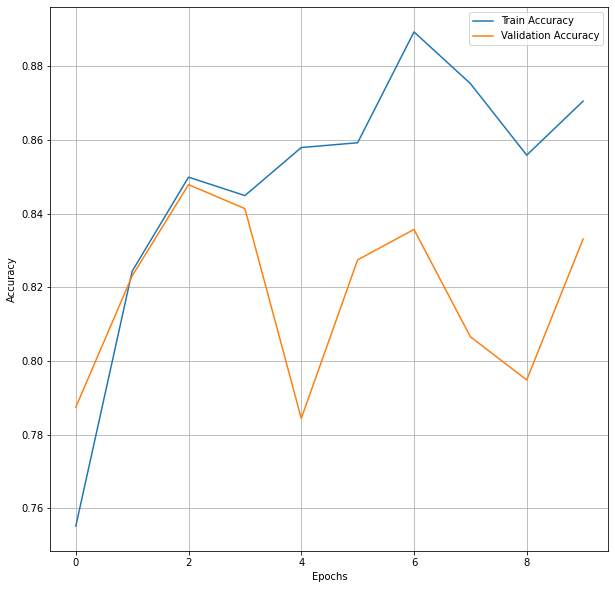

In [15]:
plt.figure(figsize=(10,10))
history_df2 = pd.DataFrame(history_mlp.history)
plt.plot(history_df2.accuracy,label="Train Accuracy")
plt.plot(history_df2.val_accuracy,label="Validation Accuracy")
plt.xlabel("Epochs"),
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

The above plot gives the accuracy for the train and validation data. As we can see that the blue line depicts the training data accuracy and the yellow line depicts the validation data accuracy. The training accuracy for the first epoch was around 75% and then gradually increased and reached its peak to 88% in the 6th epoch.The validation data accuracy has been range bound and is in between 79% to 85% and is around 83% in the 10th epoch.

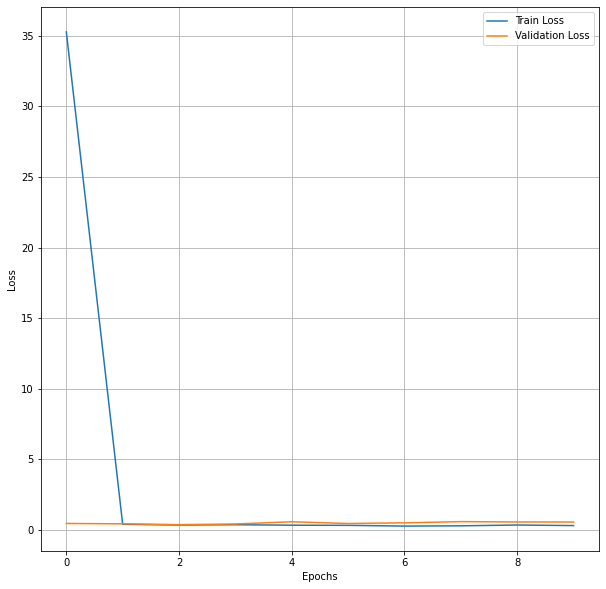

In [16]:
plt.figure(figsize=(10,10))
plt.plot(history_df2.loss,label="Train Loss")
plt.plot(history_df2.val_loss,label="Validation Loss")
plt.xlabel("Epochs"),
plt.ylabel("Loss")
plt.legend()
plt.grid()

The above graph displays the training and validation data loss for the multilayer perceptron model. From the above graph, we can see that the train data loss drastically dips from 35 to 0.3 and then becomes linear throughout the graph. The validation data loss, however, is completely linear throughout the 10 epochs.

## CNN Model

In [17]:
scaler = keras.Sequential([keras.layers.Rescaling(1/255)])

In [18]:
augmentation = keras.Sequential([keras.layers.RandomZoom(0.2),
                                keras.layers.RandomRotation(0.3),
                                keras.layers.RandomFlip("horizontal")])

In [19]:
model_cnn = keras.Sequential([scaler,
                          keras.layers.Conv2D(16,kernel_size=3,strides=1,input_shape=(75,75,3)),
                          keras.layers.Conv2D(32,kernel_size=3,strides=1),
                          keras.layers.BatchNormalization(),
                          keras.layers.Activation("relu"),
                          keras.layers.MaxPooling2D(2),
                          keras.layers.Dropout(0.2),
                          keras.layers.Conv2D(64,kernel_size=3,strides=1),
                          keras.layers.BatchNormalization(),
                          keras.layers.Activation("relu"),
                          keras.layers.MaxPooling2D(2),         
                          keras.layers.Dropout(0.2),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128,activation="relu"),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(1,activation="sigmoid")])

In [20]:
model_cnn.compile(loss="binary_crossentropy",metrics=["accuracy"],optimizer="adam")
early_stop = keras.callbacks.EarlyStopping(patience=3)

The model_cnn is a CNN Model. Since the label is binary, the input dimension of the output layer is set to 1 and the activation used is sigmoid. Here I am using Flatten because without it the model was giving a dimension mis match error. Hence, I am using Flatten() to get a copy of the given array of data collapsed in one dimension. I am using maxpooling to downsample the the output by half. BatchNormalization is a technique that normalizes the inputs to a network, this inturn makes the neural network faster and hence I am using BatchNormalization. Dropout is used to prevent overfitting of the model. I am using dropout as it increased the performance of my model.

In [21]:
history_cnn = model_cnn.fit(train,validation_data=validation,epochs=10,callbacks=early_stop)

Epoch 1/10
288/288 [==============================] - 44s 149ms/step - loss: 0.6439 - accuracy: 0.7680 - val_loss: 0.4667 - val_accuracy: 0.7597
Epoch 2/10
288/288 [==============================] - 42s 147ms/step - loss: 0.3567 - accuracy: 0.8446 - val_loss: 0.3145 - val_accuracy: 0.8609
Epoch 3/10
288/288 [==============================] - 43s 150ms/step - loss: 0.3126 - accuracy: 0.8661 - val_loss: 0.2446 - val_accuracy: 0.8935
Epoch 4/10
288/288 [==============================] - 43s 150ms/step - loss: 0.2796 - accuracy: 0.8828 - val_loss: 0.2800 - val_accuracy: 0.8861
Epoch 5/10
288/288 [==============================] - 43s 151ms/step - loss: 0.2461 - accuracy: 0.8988 - val_loss: 0.2461 - val_accuracy: 0.8992
Epoch 6/10
288/288 [==============================] - 44s 152ms/step - loss: 0.2368 - accuracy: 0.9030 - val_loss: 0.2340 - val_accuracy: 0.9092
Epoch 7/10
288/288 [==============================] - 43s 148ms/step - loss: 0.2199 - accuracy: 0.9098 - val_loss: 0.2120 - val_ac

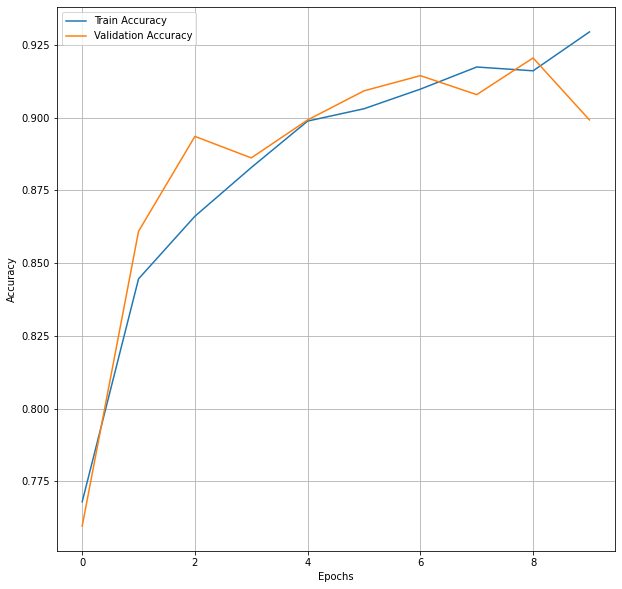

In [22]:
history_df3 = pd.DataFrame(history_cnn.history)
plt.figure(figsize=(10,10))
plt.plot(history_df3.accuracy,label="Train Accuracy")
plt.plot(history_df3.val_accuracy,label="Validation Accuracy")
plt.xlabel("Epochs"),
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

The above graph plots the accuracy curve for the train and validation data for the CNN model. As we can see, the curve for both the datasets start from around 76% and increases drastically till the 10th epoch closing around 92% for training data and 90% for validation data.

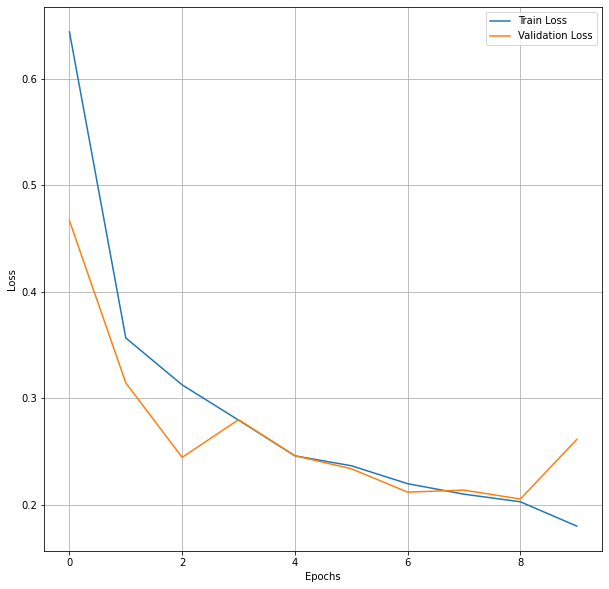

In [23]:
plt.figure(figsize=(10,10))
plt.plot(history_df3.loss,label="Train Loss")
plt.plot(history_df3.val_loss,label="Validation Loss")
plt.xlabel("Epochs"),
plt.ylabel("Loss")
plt.legend()
plt.grid()

The above graph represnts the loss curve for the training and validation data.The training data curve starts from 0.65 and decreases gradually with the increase in the number of epochs and is around 0.18 in the 10th epoch. The validation data loss start from 0.46 and is around 0.26 in the 10th epoch with some fluctuations.

## Conclusion

In this entire project, I have created 3 models, the first one using KNN, the second is a multilayer perceptron model without using any Sklearn algorithm and the final one is a CNN model.<br>
Based on the accuracy, we can see that the KNN model had an accuracy of around 81%, the multilayer perceptron model had the best accuracy of 82% on the validation data and the CNN model had the best accuracy of 92% on the validation model.<br>
The multilayer perceptron model and the CNN model have a similar kind of accuracy and loss graph with the loss decreasing gradually with the number of epochs and the accuracy increasing with the number of epochs. However, the loss of the CNN model is lower than that of the multilayer perceptron model.<br>
The data mentioned above clearly indicated that the CNN model (model 3) performed better than the other models. The multilayer perceptron model (model 2) perfomed better the KNN model (model 1). <br>
Hence, the CNN model performed the best